In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [2]:
# Load the data
malwares = pd.read_json('malwares small.json', orient='records')

# Show the first 5 rows of the dataframe
malwares.head()

,sha256,classification_family,classification_type,date,behavior.summary.keys,behavior.summary.resolved_apis,behavior.summary.executed_commands,behavior.summary.write_keys,behavior.summary.files,behavior.summary.read_files,...,static.pe.dirents,static.pe.versioninfo,static.pe.resources,static.pe.pdbpath,static.pe.osversion,static.pe.icon_fuzzy,static.pe.imagebase,static.pe.imported_dll_count,static.pe.timestamp,static.pe.overlay
0,bdef5dce6c4a291c9baccf7da2f69598d4e25d6f2e9a41...,Trickbot,banker,2019-10-04,[HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Cryptog...,"[kernel32.dll.LoadLibraryA, ntdll.dll.RtlDecom...",[],[],[],[],...,"[{'name': 'IMAGE_DIRECTORY_ENTRY_EXPORT', 'vir...",[],"[{'name': 'RT_MANIFEST', 'filetype': None, 'of...",None,4.0,None,0x00400000,2.0,2076-03-29 07:05:08,NaN
1,54dbacf6adf0dff6a92ce783cf938c952a9c2a102c7fc2...,Emotet,banker,2018-09-03,[HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Windows...,"[winspool.drv.#218, winspool.drv.#217, winspoo...","[""C:\Users\comp\AppData\Local\Temp\54DBACF6ADF...",[HKEY_CURRENT_USER\Software\Microsoft\Windows\...,[C:\Users\comp\AppData\Local\Temp\\x73ce\xfd24...,[C:\Windows\Globalization\Sorting\sortdefault....,...,"[{'name': 'IMAGE_DIRECTORY_ENTRY_EXPORT', 'vir...",[],[],None,4.0,None,0x00400000,16.0,2018-09-03 20:30:14,NaN
2,45739ef7dc1eb7164b9cdaa9dcbd5a82f996a328917e79...,Emotet,banker,2018-05-22,[HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\C...,"[kernel32.dll.GetNativeSystemInfo, kernel32.dl...","[""C:\Users\comp\AppData\Local\Microsoft\Window...",[HKEY_CURRENT_USER\Software\Microsoft\Windows\...,"[C:\Windows\SysWOW64\en-US\SETUPAPI.dll.mui, C...","[C:\Windows\SysWOW64\en-US\SETUPAPI.dll.mui, C...",...,"[{'name': 'IMAGE_DIRECTORY_ENTRY_EXPORT', 'vir...",[],"[{'name': 'RT_VERSION', 'filetype': None, 'off...",None,5.0,None,0x00400000,19.0,2018-05-23 03:46:46,NaN
3,b9052008b1be8ff2d117d987fafa732b14ecef2300ee6f...,Emotet,banker,2018-04-29,[HKEY_LOCAL_MACHINE\System\CurrentControlSet\C...,"[kernel32.dll.AddVectoredExceptionHandler, ker...","[cmd.exe /C move /Y ""C:\Users\comp\AppData\Loc...",[HKEY_CURRENT_USER\Software\Microsoft\Windows\...,"[C:\Windows\SysWOW64\en-US\SETUPAPI.dll.mui, C...","[C:\Windows\SysWOW64\en-US\SETUPAPI.dll.mui, C...",...,"[{'name': 'IMAGE_DIRECTORY_ENTRY_EXPORT', 'vir...",[],"[{'name': 'RT_STRING', 'filetype': None, 'offs...",None,5.0,None,0x00400000,7.0,2018-04-29 23:26:19,NaN
4,323154c4cb75b02983bc4e076be06997644eb8852384aa...,Emotet,banker,2019-04-24,"[DisableUserModeCallbackFilter, HKEY_LOCAL_MAC...","[kernel32.dll.HeapAlloc, kernel32.dll.HeapFree...","[--32e964d1, C:\Users\comp\AppData\Local\Temp\...",[],[C:\Users\comp\AppData\Local\Temp\\x656a\x6963...,[C:\Windows\Globalization\Sorting\sortdefault....,...,"[{'name': 'IMAGE_DIRECTORY_ENTRY_EXPORT', 'vir...",[],"[{'name': 'RT_DIALOG', 'filetype': None, 'offs...",None,5.1,None,0x00400000,3.0,2014-09-17 23:06:57,NaN


In [3]:
# Check the number of samples for each classification type
malwares['classification_family'].value_counts()

classification_family
njRAT       1529
Lokibot     1500
Swisyn      1422
Emotet       765
HarHar       655
Qakbot       279
Trickbot     232
Zeus         140
Ursnif        84
Adload        78
Name: count, dtype: int64

In [4]:
def hexToDecimal(hex):
    if str(hex) == 'nan' or str(hex) == 'None':
        return 0
    else:
        return int(str(hex), 16)

# Transform lists of strings into strings
malwares['behavior.summary.keys'] = malwares['behavior.summary.keys'].apply(' '.join)
malwares['behavior.summary.resolved_apis'] = malwares['behavior.summary.resolved_apis'].apply(' '.join)
malwares['behavior.summary.executed_commands'] = malwares['behavior.summary.executed_commands'].apply(' '.join)
malwares['behavior.summary.write_keys'] = malwares['behavior.summary.write_keys'].apply(' '.join)
malwares['behavior.summary.files'] = malwares['behavior.summary.files'].apply(' '.join)
malwares['behavior.summary.read_files'] = malwares['behavior.summary.read_files'].apply(' '.join)
malwares['behavior.summary.write_files'] = malwares['behavior.summary.write_files'].apply(' '.join)

# Convert string into bag of word
vectorizer = CountVectorizer()
malwares['behavior.summary.keys'] = vectorizer.fit_transform(malwares['behavior.summary.keys']).toarray()
malwares['behavior.summary.resolved_apis'] = vectorizer.fit_transform(malwares['behavior.summary.resolved_apis']).toarray()
malwares['behavior.summary.executed_commands'] = vectorizer.fit_transform(malwares['behavior.summary.executed_commands']).toarray()
malwares['behavior.summary.write_keys'] = vectorizer.fit_transform(malwares['behavior.summary.write_keys']).toarray()
malwares['behavior.summary.files'] = vectorizer.fit_transform(malwares['behavior.summary.files']).toarray()
malwares['behavior.summary.read_files'] = vectorizer.fit_transform(malwares['behavior.summary.read_files']).toarray()
malwares['behavior.summary.write_files'] = vectorizer.fit_transform(malwares['behavior.summary.write_files']).toarray()

# Convert hex to decimal
malwares['static.pe.reported_checksum'] = malwares['static.pe.reported_checksum'].apply(hexToDecimal)
malwares['static.pe.actual_checksum'] = malwares['static.pe.actual_checksum'].apply(hexToDecimal)
malwares['static.pe.entrypoint'] = malwares['static.pe.entrypoint'].apply(hexToDecimal)

columns = [
    'behavior.summary.keys',
    'behavior.summary.resolved_apis',
    'behavior.summary.executed_commands',
    'behavior.summary.write_keys',
    'behavior.summary.files',
    'behavior.summary.read_files',
    'behavior.summary.write_files',
    'static.pe.osversion',
    'static.pe.imported_dll_count',
    'static.pe.guest_signers.aux_valid',
    'static.pe.reported_checksum',
    'static.pe.actual_checksum',
    'static.pe.entrypoint']
X = malwares[columns].values.reshape(-1, len(columns))
y = malwares['classification_family'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Replace NaN values with the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Print shapes
print(X_train.shape)
print(X_test.shape)

(6015, 13)
(669, 13)


In [5]:
# Convert string labels to numerical values
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train.ravel())
y_test_label = label_encoder.transform(y_test.ravel())

# Create the XG Boost model
model = xgb.XGBClassifier(max_depth=0)
model.fit(X_train, y_train_label)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

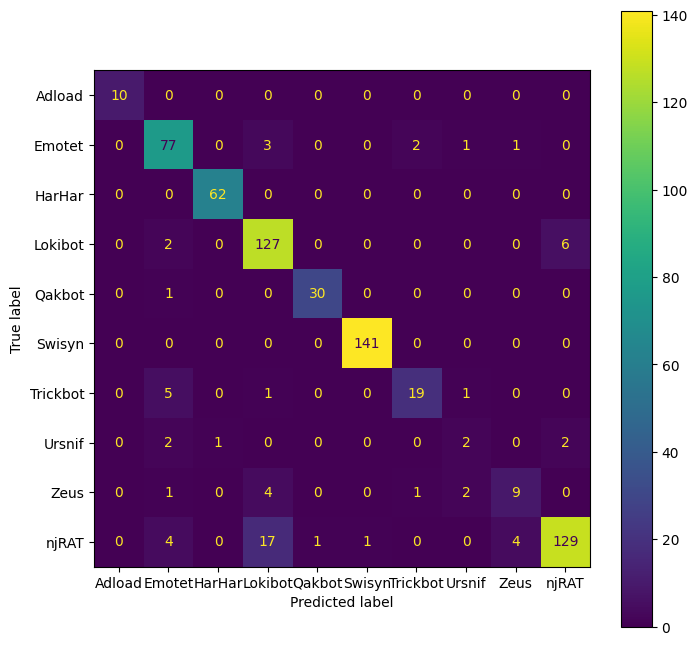

In [6]:
# Print confusion matrix
plt.rcParams['figure.figsize'] = [8, 8]
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test_label, y_pred)
labels = np.unique(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [7]:
# Print the training & test accuracy
print('Training accuracy:', round(model.score(X_train, y_train_label) * 100, 2), '%')
print('Test accuracy:', round(model.score(X_test, y_test_label) * 100, 2), '%')

Training accuracy: 99.29 %
Test accuracy: 90.58 %
